# Step 1 — Threshold Rule + Anchor Quality (Behavioral Extension)

**Goal:**  
Introduce behavioral realism by adding two movement rules — the **threshold rule** and **anchor quality**.  
Customers no longer move purely at random: their decisions depend on the similarity of nearby stores and the attractiveness of the anchor.

---

**Why Step 1 matters**  
- Adds **social clustering** behavior (agents prefer similar stores).  
- Captures **anchor influence** on staying and spillover effects.  
- Moves the model beyond random movement toward *realistic retail dynamics*.

---

**Key assumptions**  
- Each agent checks the proportion of **same-category neighbors** before moving.  
- If the ratio ≥ `theta_same`, the agent moves toward a similar store.  
- Otherwise, it moves randomly or stays put.  
- Anchors have a probability `p_stay_anchor` of keeping agents longer (anchor quality).  
- Higher-quality anchors concentrate traffic, but too high a value reduces diffusion.

---

**Parameters introduced**  
| Parameter | Meaning | Example values |
|------------|----------|----------------|
| `theta_same` | Minimum ratio of same-category neighbors required to move | 0.4 = diffusion ↑ 0.8 = clustering ↑ |
| `p_stay_anchor` | Probability of staying longer at anchor (anchor quality) | 0.3 = medium 0.5 = high |

---

**Expected patterns**  
- **Higher `theta_same` →** stronger clustering, reduced exploration.  
- **Higher `p_stay_anchor` →** more footfall at the anchor and 1-hop neighbors.  
- Moderate values (e.g., `theta_same = 0.6`, `p_stay_anchor = 0.3`) give balanced diffusion and clustering.

In [ ]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")   # 노트북이 notebooks/ 안에 있을 때 가정
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "src"))
sys.path.append(os.path.join(PROJECT_ROOT, "utils"))

print("Project root:", PROJECT_ROOT)

import numpy as np
import pandas as pd
import networkx as nx
from dataclasses import dataclass

try:
    from utils import ensure_dir
except Exception:
    from utils.io import ensure_dir

try:
    from utils.random_tools import set_seed
    from utils.plotting import set_palette
    set_seed(42)
    set_palette(style='whitegrid', context='talk', palette='Set2')
except Exception as e:
    print("Optional styling utils not found or failed:", e)


Project root: /workspaces/Modeling
[Seaborn] style=whitegrid, context=talk, palette=Set2


In [7]:
@dataclass
class Params:
    n_nodes: int = 20
    n_anchors: int = 1
    steps: int = 10
    theta_same: float = 0.6   # threshold: min ratio of same-category neighbors
    p_edge: float = 0.2
    n_agents: int = 100
    p_stay_anchor: float = 0.3  # anchor quality: dwell probability at anchor
    seed: int = 1
    count_t0: bool = True       # whether to count t=0 (initial positions)

def build_mall(params: Params):
    rng = np.random.default_rng(params.seed)
    G = nx.erdos_renyi_graph(params.n_nodes, params.p_edge, seed=params.seed)
    anchors = set(rng.choice(params.n_nodes, params.n_anchors, replace=False))
    for n in G.nodes:
        if n in anchors:
            G.nodes[n]["role"] = "anchor"
            G.nodes[n]["category"] = "similar"
            G.nodes[n]["A"] = 3   # quality weight
        else:
            G.nodes[n]["role"] = "tenant"
            G.nodes[n]["category"] = rng.choice(["similar", "different"])
            G.nodes[n]["A"] = 1
    return G, anchors

In [11]:
def simulate(params: Params) -> pd.DataFrame:
    rng = np.random.default_rng(params.seed)
    G, anchors = build_mall(params)
    A0 = next(iter(anchors))

    customers = np.full(params.n_agents, A0, dtype=int)         # FIX 1
    footfall = np.zeros(params.n_nodes, dtype=int)

    if params.count_t0:
        footfall += np.bincount(customers, minlength=params.n_nodes)

    for _ in range(params.steps):
        for i in range(len(customers)):
            here = customers[i]
            neighbors = list(G.neighbors(here))
            if not neighbors:
                neighbors = [here] 

            curr_cat = G.nodes[here]["category"]
            same_neighbors = [v for v in neighbors if G.nodes[v]["category"] == curr_cat]
            ratio_same = len(same_neighbors) / len(neighbors) if neighbors else 0.0

            
            if G.nodes[here]["role"] == "anchor" and rng.random() < params.p_stay_anchor:  # FIX 2
                nxt = here
         
            elif same_neighbors and ratio_same >= params.theta_same:
                nxt = int(rng.choice(same_neighbors))
            
            else:
                pool = neighbors + [here]  
                weights = np.array([G.nodes[v]["A"] for v in pool], dtype=float)
                probs = weights / weights.sum()
                nxt = int(rng.choice(pool, p=probs))

            customers[i] = nxt
            footfall[nxt] += 1

    df = pd.DataFrame({
        "node": np.arange(params.n_nodes),
        "role": [G.nodes[n]["role"] for n in G.nodes],
        "category": [G.nodes[n]["category"] for n in G.nodes],
        "footfall": footfall
    })
    ensure_dir("data/outputs")
    df.to_csv("data/outputs/step1.csv", index=False)
    print("[Saved] data/outputs/step1.csv")
    return df


In [ ]:
p = Params(theta_same=0.6, p_stay_anchor=0.3, count_t0=True)
df = simulate(p)

total = int(df["footfall"].sum())
expected = p.n_agents * (p.steps + int(p.count_t0))
print(f"Total footfall: {total} | Expected: {expected}")
assert total == expected, "Total footfall mismatch!"
print("✅ Simulation totals are correct.")

anchor_avg = df.query("role=='anchor'")["footfall"].mean()
tenant_avg = df.query("role=='tenant'")["footfall"].mean()
print(f"Anchor avg: {anchor_avg:.2f} | Tenant avg: {tenant_avg:.2f}")

df.head()

[Saved] data/outputs/step1.csv
Total footfall: 1100 | Expected: 1100
✅ Simulation totals are correct.
Anchor avg: 351.00 | Tenant avg: 39.42


,node,role,category,footfall
0,0,tenant,different,20
1,1,tenant,different,11
2,2,tenant,different,9
3,3,tenant,similar,16
4,4,tenant,similar,24


[Saved] figs/step1_footfall.png


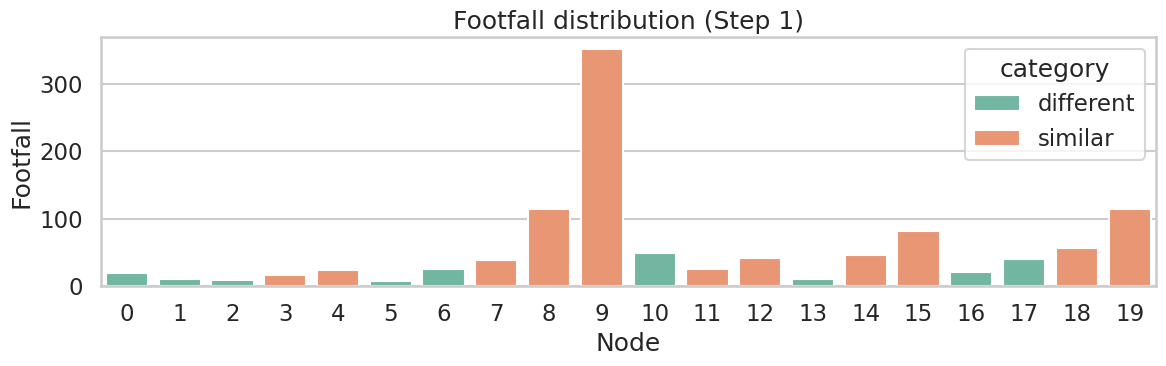

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
sns.barplot(data=df.sort_values("node"), x="node", y="footfall", hue="category")
plt.title("Footfall distribution (Step 1)")
plt.xlabel("Node"); plt.ylabel("Footfall")

ensure_dir("figs")
plt.tight_layout()
plt.savefig("figs/step1_footfall.png", dpi=150)
print("[Saved] figs/step1_footfall.png")
plt.show()

In [14]:
def summarize(df: pd.DataFrame) -> pd.DataFrame:
    total = int(df["footfall"].sum())
    anchor_total = int(df.loc[df["role"]=="anchor","footfall"].sum())
    return pd.DataFrame({
        "metric": ["total","anchor_total","anchor_share","similar_total","different_total"],
        "value": [
            total,
            anchor_total,
            anchor_total/total if total else 0.0,
            int(df.loc[df["category"]=="similar","footfall"].sum()),
            int(df.loc[df["category"]=="different","footfall"].sum()),
        ]
    })

summarize(df)

,metric,value
0,total,1100.000000
1,anchor_total,351.000000
2,anchor_share,0.319091
3,similar_total,907.000000
4,different_total,193.000000


## **Step 0 vs Step 1 — Interpretation & Insight**

- Consistency: Both steps work correctly — total footfall = agents × (steps + t₀).

- Traffic change: In Step 1, people move more toward anchor and similar nodes.

- Behavior rule effects:

    - θ_same = 0.6 → People like similar stores, so social clustering appears.
    - p_stay_anchor = 0.3 → People stay longer at the anchor, and nearby stores get a spillover effect.

- Result: Random movement in Step 0 becomes an anchor-centered and same-type cluster pattern in Step 1.

- Strategic meaning:
The mix of anchor quality (0.3) and similarity preference (0.6)
    - makes people gather more,
    - but still keeps some spread in movement.

This design helps guide shoppers into an “anchor-centered + similarity-clustered” flow,
making them stay longer and increase sales potential inside the mall.